**Feature Engineering**

Создал 3 категориальных признака, планируя "схлопнуть" числовые, однако оказалось, что числовые лучше оставить. Для создания категориальных признаков разбивал на бины по 25 и 75 процентилям.

Преобразовал дату в более удобный вид, что немного улучшило MSE, но на валидацинной выборке я заметил, что модель переобучается на этих признаках (Year, Month), поэтому было решено не использовать их при обучении.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
import matplotlib.pyplot as plt
import seaborn as sns

# при сабмите на каггле случайно убрал X2 house age из трейна, поэтому результат может отличаться

NUMERIC_FEATURES = ['X2 house age', 'X3 distance to the nearest MRT station',
                    'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
CATEGORICAL_FEATURES = ['X3_category', 'X4_category', 'X2_category']

def preprocess_data(df, is_train=True):
    df = df.copy()

    # обработка выбросов для тренировочных данных
    if is_train:
        for col in NUMERIC_FEATURES:
            lower = df[col].quantile(0.01)
            upper = df[col].quantile(0.99)
            df[col] = df[col].clip(lower, upper)

    # преобразование даты
    df['Year'] = np.floor(df['X1 transaction date']).astype(int)
    df['Month'] = ((df['X1 transaction date'] - df['Year']) * 12 + 1).astype(int)
    df.drop(columns=['X1 transaction date'], inplace=True)

    # создание категориальных признаков
    df['X2_category'] = pd.cut(df['X2 house age'],
                               bins=[-1, 10, 30, np.inf],
                               labels=['new', 'medium', 'old'])
    df['X3_category'] = pd.cut(df['X3 distance to the nearest MRT station'],
                               bins=[-1, 290, 1400, np.inf],
                               labels=['close', 'medium', 'far'])
    df['X4_category'] = pd.cut(df['X4 number of convenience stores'],
                               bins=[-1, 1, 6, np.inf],
                               labels=['few', 'medium', 'many'])

    return df

Логарифмирую целевую переменную, чтобы избавиться от ассиметрии

In [ ]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    train_processed = preprocess_data(train_data, is_train=True)
    test_processed = preprocess_data(test_data, is_train=False)

    X_train = train_processed.drop(columns=['Y house price of unit area'])
    y_train = np.log1p(train_processed['Y house price of unit area'])

    return X_train, y_train, test_processed

In [ ]:
X_train, y_train, test_data = load_data("prices_train.csv", "prices_test.csv")

In [ ]:
def plot_distributions(original, transformed):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(original, kde=True, color='blue')
    plt.title('Original Target')
    plt.xlabel('House Price of Unit Area')

    plt.subplot(1, 2, 2)
    sns.histplot(transformed, kde=True, color='green')
    plt.title('Log Target')
    plt.xlabel('log1p(House Price of Unit Area)')

    plt.tight_layout()
    plt.show()

Из графиков видно, что логарифмирование избавляет от правого хвоста в распределении целевой переменной

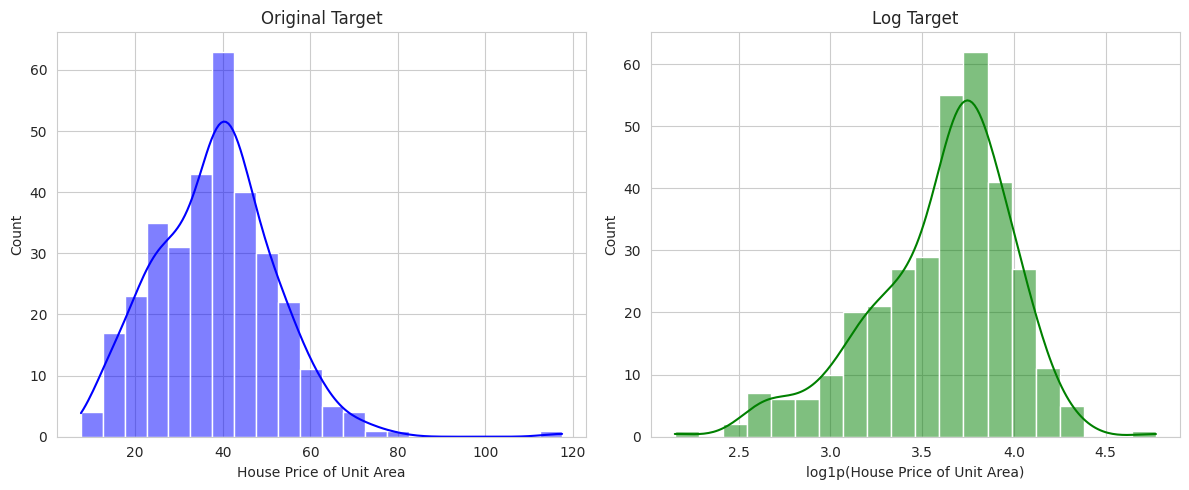

In [ ]:
original_target = np.expm1(y_train)
plot_distributions(original_target, y_train)

NaN-ы заполняю для числовых средним, а для категориальных модой. Добавляю полиномиальные признаки 3-ей степени. Из протестированных моделей лучше всего себя показала ElasticNet

In [ ]:
def create_pipeline():
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, include_bias=False))
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, NUMERIC_FEATURES),
        ('cat', cat_pipeline, CATEGORICAL_FEATURES)
    ])

    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet(max_iter=10000))
    ])

Оптимизация гиперпараметров

In [ ]:
def configure_search(pipeline):
    param_dist = {
        'regressor__alpha': loguniform(1e-4, 10),
        'regressor__l1_ratio': uniform(0, 1)
    }

    return RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=30,
        scoring='neg_mean_squared_error',
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

In [ ]:
pipeline = create_pipeline()
search = configure_search(pipeline)

# обучение модели
search.fit(X_train, y_train)

print("Best parameters:")
print(search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters:
{'regressor__alpha': np.float64(0.0028888383623653178), 'regressor__l1_ratio': np.float64(0.3663618432936917)}


In [ ]:
def evaluate_model(model, X, y):
    preds = np.expm1(model.predict(X))
    y_true = np.expm1(y)

    metrics = {
        'MAE': mean_absolute_error(y_true, preds),
        'MSE': mean_squared_error(y_true, preds),
        'RMSE': np.sqrt(mean_squared_error(y_true, preds)),
        'R2': r2_score(y_true, preds)
    }

    return metrics

In [ ]:
print("Training metrics:")
best_model = search.best_estimator_
evaluate_model(best_model, X_train, y_train)

Training metrics:


{'MAE': 4.356721815350513,
 'MSE': 49.95732027910949,
 'RMSE': np.float64(7.06804925556617),
 'R2': 0.7355874204213328}

In [ ]:
def save_predictions(model, test_data, filename):
    predictions = np.expm1(model.predict(test_data))
    submission = pd.DataFrame({
        'index': test_data.index,
        'Y house price of unit area': predictions
    })
    submission.to_csv(filename, index=False)

In [ ]:
save_predictions(best_model, test_data, "submission.csv")